<a href="https://colab.research.google.com/github/trinaxavier2001/SkinLesionClassification/blob/main/ResNet50_focalLoss_CrossValidationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.

In [ ]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from sklearn.model_selection   import StratifiedKFold, train_test_split
from sklearn.preprocessing     import LabelEncoder
from sklearn.metrics           import accuracy_score, f1_score
from torch.utils.data          import Dataset, DataLoader, WeightedRandomSampler
from torchvision               import transforms
from torchvision.transforms    import AutoAugment, AutoAugmentPolicy
from torchvision.models        import (
    resnet50, ResNet50_Weights,
    efficientnet_b4, EfficientNet_B4_Weights,
    efficientnet_b5, EfficientNet_B5_Weights
)
from torch.amp                 import autocast, GradScaler
from torch.optim               import AdamW
from torch.optim.lr_scheduler  import OneCycleLR

In [ ]:
# ─── HYPERPARAMETERS ─────────────────────────────────────────────────────────
BASE_DIR           = '/content/drive/MyDrive/Skin_Disease_Model'
CSV_PATH           = os.path.join(BASE_DIR, 'metadata_with_image_descriptions.csv')
BATCH_SIZE         = 32
HEAD_WARMUP_EPOCHS = 2
STAGE2_EPOCHS      = 18
STAGE3_EPOCHS      = 26
MAX_LR_HEAD        = 1e-3
MAX_LR_STAGE2      = 3e-4
MAX_LR_STAGE3      = 5e-5
WEIGHT_DECAY       = 1e-2
WD_RAMP_EPOCHS     = 15             # slower ramp to full L2
GAMMA_FOCAL        = 2.0
LABEL_SMOOTHING    = 0.1
BETA_TVERSKY       = 0.7
ALPHA_TVERSKY      = 0.3
TV_GAMMA           = 1.0
TV_WEIGHT          = 0.1
OVERSAMPLE_RAMP    = (5, 12)        # ramp 1→0.3 between 5–12, hold 0.3 until Stage2 end
MIXUP_ALPHA        = 0.4
DEVICE             = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
label_encoder      = LabelEncoder()

In [ ]:
# where to stash resume checkpoints
RESUME_DIR = os.path.join(BASE_DIR, "resumes")
os.makedirs(RESUME_DIR, exist_ok=True)


# ─── DATA & TRANSFORMS ────────────────────────────────────────────────────────
all_images = glob.glob(str(Path(BASE_DIR)/"HAM10000_images_part_*" / "*.jpg"))
path_map   = { Path(p).stem: p for p in all_images }

class HAM10000Dataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.tf = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row.file_path).convert('RGB')
        return self.tf(img), row.label

light_tf = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

heavy_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02,0.2)),
])

auto_heavy_tf = transforms.Compose([
    AutoAugment(AutoAugmentPolicy.IMAGENET),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(15),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.3, scale=(0.02,0.2)),
])

val_tf = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

def preprocess_df(path):
    df = pd.read_csv(path)
    df['file_path'] = df['image_id'].map(path_map)
    df['label']     = label_encoder.fit_transform(df['dx'])
    return df
print(preprocess_df(CSV_PATH).head())

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset                           gemini_image_description  \
0  vidir_modern  The image shows disease benign keratosis-like ...   
1  vidir_modern  The image shows disease benign keratosis-like ...   
2  vidir_modern  The image shows disease benign keratosis-like ...   
3  vidir_modern  The image shows disease benign keratosis-like ...   
4  vidir_modern  The image shows disease benign keratosis-like ...   

                                           file_path  label  
0  /content/drive/MyDrive/Skin_Disease_Model/HAM1...      2  
1  /content/drive/MyDrive/Skin_Dis

In [ ]:
# ─── HYBRID FOCAL‑TVERSKY LOSS ────────────────────────────────────────────────
class HybridFocalTverskyLoss(nn.Module):
    def __init__(self, alpha, gamma=GAMMA_FOCAL,
                 smooth=LABEL_SMOOTHING,
                 t_alpha=ALPHA_TVERSKY, t_beta=BETA_TVERSKY,
                 t_gamma=TV_GAMMA, t_weight=TV_WEIGHT):
        super().__init__()
        self.alpha, self.gamma, self.smooth = alpha, gamma, smooth
        self.t_a, self.t_b, self.t_g, self.t_w = t_alpha, t_beta, t_gamma, t_weight

    def forward(self, logits, targets):
        # Focal part
        w  = self.alpha.to(logits.device)
        ce = F.cross_entropy(
            logits, targets,
            weight=w,
            reduction='none',
            label_smoothing=self.smooth
        )
        p_t   = torch.exp(-ce)
        focal = ((1 - p_t)**self.gamma * ce).mean()

        # Tversky part
        probs   = F.softmax(logits, dim=1)
        one_hot = F.one_hot(targets, num_classes=probs.size(1)).float()
        TP = (probs * one_hot).sum(0)
        FP = (probs * (1 - one_hot)).sum(0)
        FN = ((1 - probs) * one_hot).sum(0)
        T  = TP / (TP + self.t_a*FP + self.t_b*FN + 1e-6)
        tv_loss = ((1 - T)**self.t_g).mean()

        return focal + self.t_w * tv_loss

In [ ]:
# ─── ENSEMBLE: ResNet50 + EfficientNet‑B4 + EfficientNet‑B5 ─────────────────
class EnsembleModel(nn.Module):
    def __init__(self, num_classes, dropout_p=0.5, hidden_dim=512):
        super().__init__()
        # ResNet50
        res    = resnet50(weights=ResNet50_Weights.DEFAULT)
        res_in = res.fc.in_features; res.fc = nn.Identity()
        # EfficientNet‑B4
        e4     = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
        e4_in  = e4.classifier[1].in_features; e4.classifier = nn.Identity()
        # EfficientNet‑B5
        e5     = efficientnet_b5(weights=EfficientNet_B5_Weights.DEFAULT)
        e5_in  = e5.classifier[1].in_features; e5.classifier = nn.Identity()

        self.backbone_res = res
        self.backbone_e4  = e4
        self.backbone_e5  = e5

        self.head = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(res_in + e4_in + e5_in, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        f1 = self.backbone_res(x)
        f2 = self.backbone_e4(x)
        f3 = self.backbone_e5(x)
        return self.head(torch.cat([f1, f2, f3], dim=1))

In [ ]:
# ─── MIXUP ───────────────────────────────────────────────────────────────────
def mixup_data(x, y, alpha=MIXUP_ALPHA):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], y, y[idx], lam


# ─── TRAIN / VALIDATE ────────────────────────────────────────────────────────
def train_epoch(df_tr, model, crit, optimizer, scheduler, scaler, epoch):
    model.train()
    preds, labs, tot = [], [], 0.0

    # 1) build soft‑oversample ratio
    counts   = df_tr.label.value_counts().sort_index()
    inv_sqrt = 1.0 / np.sqrt(counts)
    e0, e1   = OVERSAMPLE_RAMP
    if   epoch <= e0:
        ratio = 1.0
    elif epoch <= e1:
        ratio = 1 - (epoch - e0)/(e1 - e0)
    elif epoch <= STAGE2_EPOCHS:
        ratio = 0.3           # hold a 30% mix until end of Stage2
    else:
        ratio = 0.0
    samp_wts = df_tr['label'].map(inv_sqrt).values * ratio + (1 - ratio)

    # 2) choose augment based on epoch
    if   epoch <= HEAD_WARMUP_EPOCHS:
        tf = light_tf
    elif epoch <= HEAD_WARMUP_EPOCHS + 2:
        tf = light_tf         # delay heavy by 2 iters
    elif epoch <= (HEAD_WARMUP_EPOCHS + STAGE2_EPOCHS)//2:
        tf = heavy_tf
    else:
        tf = auto_heavy_tf

    ds = HAM10000Dataset(df_tr, tf)
    loader = (DataLoader(ds, BATCH_SIZE,
                         sampler=WeightedRandomSampler(samp_wts,
                                                       num_samples=len(samp_wts),
                                                       replacement=True),
                         num_workers=2, pin_memory=True)
              if ratio>0 else
              DataLoader(ds, BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True))

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        # 3) ramp weight‑decay
        wd = WEIGHT_DECAY * min(epoch/WD_RAMP_EPOCHS, 1.0)
        for pg in optimizer.param_groups:
            pg['weight_decay'] = wd

        optimizer.zero_grad()
        if epoch > HEAD_WARMUP_EPOCHS:
            x_m, y_a, y_b, lam = mixup_data(x, y)
            with autocast(device_type=DEVICE.type):
                logits = model(x_m)
                loss   = lam*crit(logits, y_a) + (1-lam)*crit(logits, y_b)
        else:
            with autocast(device_type=DEVICE.type):
                logits = model(x)
                loss   = crit(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        tot  += loss.item() * x.size(0)
        p     = logits.argmax(1)
        preds.extend(p.cpu().numpy())
        labs .extend(y.cpu().numpy())

    return tot/len(df_tr), accuracy_score(labs, preds), f1_score(labs, preds, average='macro')


@torch.no_grad()
def validate(model, loader, crit):
    model.eval()
    tot, preds, labs = 0.0, [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        with autocast(device_type=DEVICE.type):
            logits = model(x)
            loss   = crit(logits, y)
        tot  += loss.item() * x.size(0)
        p     = logits.argmax(1)
        preds.extend(p.cpu().numpy())
        labs .extend(y.cpu().numpy())

    return (tot/len(loader.dataset),
            accuracy_score(labs, preds),
            f1_score(labs, preds, average='macro'),
            preds, labs)

In [ ]:

# ─── CROSS‑VALIDATION LOOP ─────────────────────────────────────────────────
def run_cv(df, folds=5, test_size=0.10):
    trainval, test = train_test_split(df, test_size=test_size,
                                      stratify=df.label, random_state=42)
    X, y = trainval.index.values, trainval.label.values
    skf  = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    fold_scores = []

    for fold, (tr_idx, vl_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n=== Fold {fold}/{folds} ===")
        df_tr, df_vl = trainval.iloc[tr_idx], trainval.iloc[vl_idx]

        vl_loader = DataLoader(HAM10000Dataset(df_vl, val_tf),
                               batch_size=BATCH_SIZE,
                               shuffle=False, num_workers=2,
                               pin_memory=True)

        # compute class‑balanced α
        counts = df_tr.label.value_counts().sort_index()
        beta   = 0.999
        cb_wts = (1 - beta) / (1 - beta**counts)
        alpha  = torch.tensor((cb_wts/cb_wts.mean()).values,
                              dtype=torch.float32).to(DEVICE)

        # build model & loss
        model = EnsembleModel(num_classes=len(counts)).to(DEVICE)
        crit  = HybridFocalTverskyLoss(alpha)
        scaler= GradScaler()

        # ── Stage1: head‑only warmup ───────────────────────────
        head_opt   = AdamW(model.head.parameters(),
                           lr=MAX_LR_HEAD, weight_decay=WEIGHT_DECAY/10)
        head_sched = OneCycleLR(head_opt,
                                max_lr=MAX_LR_HEAD,
                                steps_per_epoch=len(df_tr)//BATCH_SIZE+1,
                                epochs=HEAD_WARMUP_EPOCHS,
                                pct_start=0.3,
                                div_factor=10,
                                final_div_factor=1e4)

        # resume head if checkpoint exists
        resume_path  = os.path.join(RESUME_DIR, f"head_fold{fold}.pth")
        start_epoch1 = 1
        if os.path.exists(resume_path):
            ck = torch.load(resume_path)
            model.load_state_dict(ck['model'])
            head_opt.load_state_dict(ck['opt'])
            head_sched.load_state_dict(ck['sched'])
            start_epoch1 = ck['epoch'] + 1
            print(f" Resuming HEAD fold{fold} at epoch {start_epoch1}")

        best_f1 = 0.0
        for ep in range(start_epoch1, HEAD_WARMUP_EPOCHS+1):
            # freeze backbone
            for net in (model.backbone_res, model.backbone_e4, model.backbone_e5):
                for p in net.parameters(): p.requires_grad = False

            tr_l, tr_a, tr_f = train_epoch(df_tr, model, crit,
                                           head_opt, head_sched, scaler, ep)
            vl_l, vl_a, vl_f, _, _ = validate(model, vl_loader, crit)
            print(f"[HEAD] Ep{ep:02d} trF1={tr_f:.3f} vlF1={vl_f:.3f}")

            # save resume
            torch.save({
                'epoch': ep,
                'model': model.state_dict(),
                'opt':   head_opt.state_dict(),
                'sched': head_sched.state_dict()
            }, resume_path)

            if vl_f > best_f1:
                best_f1 = vl_f
                torch.save(model.state_dict(),
                           os.path.join(BASE_DIR, f"best_head_fold{fold}.pth"))

        # ── Stage2: unfreeze + MixUp ──────────────────────────
        ckpt = os.path.join(BASE_DIR, f"best_head_fold{fold}.pth")
        if os.path.exists(ckpt):
            model.load_state_dict(torch.load(ckpt))
            print(f" Loaded best head for fold{fold}")

        for net in (model.backbone_res, model.backbone_e4, model.backbone_e5):
            for p in net.parameters(): p.requires_grad = True

        full_opt   = AdamW(model.parameters(),
                           lr=MAX_LR_STAGE2, weight_decay=0.0)
        full_sched = OneCycleLR(full_opt,
                                max_lr=MAX_LR_STAGE2,
                                steps_per_epoch=len(df_tr)//BATCH_SIZE+1,
                                epochs=STAGE2_EPOCHS-HEAD_WARMUP_EPOCHS,
                                pct_start=0.3,
                                div_factor=10,
                                final_div_factor=1e4)

        no_imp = 0
        for ep in range(HEAD_WARMUP_EPOCHS+1, STAGE2_EPOCHS+1):
            tr_l, tr_a, tr_f = train_epoch(df_tr, model, crit,
                                           full_opt, full_sched, scaler, ep)
            vl_l, vl_a, vl_f, preds, labs = validate(model, vl_loader, crit)
            print(f"[ST2] Ep{ep:02d} trF1={tr_f:.3f} vlF1={vl_f:.3f}")

            if vl_f > best_f1:
                best_f1 = vl_f
                no_imp   = 0
                path = os.path.join(BASE_DIR, f"best_fold{fold}.pth")
                torch.save(model.state_dict(), path)
                print(f"  → New best fold{fold}: {best_f1:.3f}")
            else:
                no_imp += 1
                if no_imp >= 5:
                    print(" → Early stopping Stage2")
                    break

        # ── Stage3: low‑LR fine‑tune ─────────────────────────
        fine_opt   = AdamW(model.parameters(),
                           lr=MAX_LR_STAGE3, weight_decay=WEIGHT_DECAY)
        fine_sched = OneCycleLR(fine_opt,
                                max_lr=MAX_LR_STAGE3,
                                steps_per_epoch=len(df_tr)//BATCH_SIZE+1,
                                epochs=STAGE3_EPOCHS-STAGE2_EPOCHS,
                                pct_start=0.3,
                                div_factor=10,
                                final_div_factor=1e4)

        for ep in range(STAGE2_EPOCHS+1, STAGE3_EPOCHS+1):
            tr_l, tr_a, tr_f = train_epoch(df_tr, model, crit,
                                           fine_opt, fine_sched, scaler, ep)
            vl_l, vl_a, vl_f, preds, labs = validate(model, vl_loader, crit)
            print(f"[FT] Ep{ep:02d} tr F1={tr_f:.3f} vl gF1={vl_f:.3f}")

            if vl_f > best_f1:
                best_f1 = vl_f
                path    = os.path.join(BASE_DIR, f"best_fold{fold}.pth")
                torch.save(model.state_dict(), path)
                print(f"  → New best fold{fold}: {best_f1:.3f}")

        print(f">>> Fold {fold} best val‑F1 = {best_f1:.3f}")
        fold_scores.append(best_f1)

    print(f"\n=== Average CV macro‑F1: {np.mean(fold_scores):.3f} ===")

In [ ]:
if __name__=="__main__":
    df = preprocess_df(CSV_PATH)
    run_cv(df)


=== Fold 1/5 ===
[HEAD] Ep01 trF1=0.446 vlF1=0.411
[HEAD] Ep02 trF1=0.593 vlF1=0.445
 Loaded best head for fold1


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[ST2] Ep03 trF1=0.356 vlF1=0.457
  → New best fold1: 0.457
[ST2] Ep04 trF1=0.392 vlF1=0.442
[ST2] Ep05 trF1=0.357 vlF1=0.561
  → New best fold1: 0.561
[ST2] Ep06 trF1=0.337 vlF1=0.589
  → New best fold1: 0.589
[ST2] Ep07 trF1=0.348 vlF1=0.561
[ST2] Ep08 trF1=0.374 vlF1=0.594
  → New best fold1: 0.594
[ST2] Ep09 trF1=0.375 vlF1=0.620
  → New best fold1: 0.620
[ST2] Ep10 trF1=0.418 vlF1=0.640
  → New best fold1: 0.640
[ST2] Ep11 trF1=0.324 vlF1=0.584
[ST2] Ep12 trF1=0.312 vlF1=0.626
[ST2] Ep13 trF1=0.347 vlF1=0.583
[ST2] Ep14 trF1=0.356 vlF1=0.632
[ST2] Ep15 trF1=0.353 vlF1=0.657
  → New best fold1: 0.657
[ST2] Ep16 trF1=0.364 vlF1=0.674
  → New best fold1: 0.674
[ST2] Ep17 trF1=0.377 vlF1=0.681
  → New best fold1: 0.681
[ST2] Ep18 trF1=0.382 vlF1=0.679
[FT] Ep19 trF1=0.404 vlF1=0.680
[FT] Ep20 trF1=0.373 vlF1=0.719
  → New best fold1: 0.719
[FT] Ep21 trF1=0.375 vlF1=0.668
[FT] Ep22 trF1=0.385 vlF1=0.708
[FT] Ep23 trF1=0.387 vlF1=0.695
[FT] Ep24 trF1=0.377 vlF1=0.704
[FT] Ep25 trF1=0.414

In [ ]:
# ─── TEST EVALUATION ─────────────────────────────────────────────────────────
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Load full DataFrame and hold out same test split you used in CV
df = preprocess_df(CSV_PATH)
_, test_df = train_test_split(df, test_size=0.10, stratify=df.label, random_state=42)

# Test DataLoader
test_loader = DataLoader(
    HAM10000Dataset(test_df, val_tf),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Load each fold's best model and collect for ensemble
models = []
for fold in range(1, 6):
    m = EnsembleModel(num_classes=len(label_encoder.classes_)).to(DEVICE)
    ckpt_path = Path(BASE_DIR) / f"best_fold{fold}.pth"
    m.load_state_dict(torch.load(ckpt_path))
    m.eval()
    models.append(m)

# Run ensemble inference
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        # get softmax from each model
        probs = [torch.softmax(m(imgs), dim=1) for m in models]
        avg_prob = torch.stack(probs, dim=0).mean(0)
        preds = avg_prob.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Print metrics
acc = accuracy_score(all_labels, all_preds)
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"\nTest Accuracy: {acc:.4f}   Macro-F1: {macro_f1:.4f}\n")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Show a few example predictions
print("Sample test predictions:")
for i in range(10):
    img_id = test_df.iloc[i].image_id
    true_lbl = label_encoder.inverse_transform([all_labels[i]])[0]
    pred_lbl = label_encoder.inverse_transform([all_preds[i]])[0]
    print(f"{img_id}: True = {true_lbl}, Pred = {pred_lbl}")



Test Accuracy: 0.8473   Macro-F1: 0.7552

              precision    recall  f1-score   support

       akiec       0.52      0.91      0.66        33
         bcc       0.73      0.96      0.83        51
         bkl       0.83      0.67      0.74       110
          df       0.67      1.00      0.80        12
         mel       0.64      0.70      0.67       111
          nv       0.95      0.88      0.92       671
        vasc       0.52      0.93      0.67        14

    accuracy                           0.85      1002
   macro avg       0.69      0.87      0.76      1002
weighted avg       0.87      0.85      0.85      1002

Sample test predictions:
ISIC_0032195: True = nv, Pred = nv
ISIC_0033670: True = mel, Pred = nv
ISIC_0034181: True = nv, Pred = nv
ISIC_0032506: True = nv, Pred = nv
ISIC_0026216: True = nv, Pred = nv
ISIC_0028580: True = nv, Pred = nv
ISIC_0031631: True = nv, Pred = nv
ISIC_0025776: True = nv, Pred = nv
ISIC_0029311: True = bkl, Pred = akiec
ISIC_0025780: T

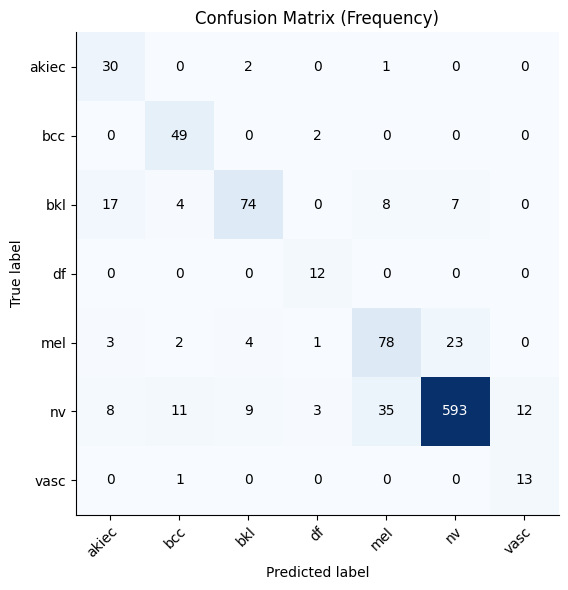

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 1) Reconstruct your class names (if you need them):
CSV_PATH = '/content/drive/MyDrive/Skin_Disease_Model/metadata_with_image_descriptions.csv'
df_meta = pd.read_csv(CSV_PATH)
le = LabelEncoder().fit(df_meta['dx'])
classes = le.classes_

# 2) Compute the confusion matrix
#    all_labels = [your true labels array]
#    all_preds  = [your predicted labels array]
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(classes)))

# 3) Plot
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm,
               interpolation='nearest',
               cmap='Blues',   # <-- nice light blue palette
               vmin=0, vmax=cm.max()*1.0)  # keep full dynamic range

# annotate each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:,}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# labels, title, ticks
ax.set(xticks=np.arange(len(classes)),
       yticks=np.arange(len(classes)),
       xticklabels=classes, yticklabels=classes,
       ylabel="True label",
       xlabel="Predicted label",
       title="Confusion Matrix (Frequency)")

# optionally remove the frame on top/right
for edge in ["top","right"]:
    ax.spines[edge].set_visible(False)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.show()
